# Projeto de Machine Learning - Previsão de Preços de Imóveis

Este projeto utiliza o conjunto de dados Ames Housing para prever preços de imóveis. Implementamos um pipeline de machine learning com pré-processamento de dados e treinamento de modelos.

## Carregamento de Dados

Inicialmente, carregamos os dados de imóveis do arquivo CSV e extraímos as colunas disponíveis.

In [48]:
import pandas as pd

df = pd.read_csv('ames.csv')
cols = pd.DataFrame({'columns': df.columns})

## Seleção de Características

Selecionamos as características numéricas e categóricas mais relevantes para nosso modelo.

In [49]:
numeric_feats = [
    'Overall.Qual', 'Gr.Liv.Area', 'Garage.Cars', 'Total.Bsmt.SF',
    'X1st.Flr.SF', 'Full.Bath', 'TotRms.AbvGrd', 'Fireplaces',
    'Year.Built', 'Year.Remod.Add'
]
categorical_feats = [
    'Exter.Qual', 'Kitchen.Qual', 'Neighborhood', 'House.Style', 'Central.Air'
]

## Transformador para Categorias Raras

Criamos um transformador personalizado que agrupa categorias pouco frequentes em uma categoria 'Other' para evitar dispersão de dados e melhorar a generalização do modelo.

In [50]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class RareCategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.frequent_categories_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in X.columns:
            freqs = X[col].value_counts(normalize=True)
            self.frequent_categories_[col] = freqs.loc[freqs >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for col, keep in self.frequent_categories_.items():
            X[col] = np.where(X[col].isin(keep), X[col], 'Other')
        return X

## Pipelines de Pré-processamento

Definimos dois pipelines distintos:

1. **Pipeline Numérico**: Realiza a imputação de valores faltantes, aplica uma transformação logarítmica para atenuar outliers e padroniza os dados.

2. **Pipeline Categórico**: Agrupa categorias raras, imputa valores faltantes e realiza codificação one-hot.

Esses pipelines são combinados em um único transformador de colunas.

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('rare', RareCategoryEncoder(threshold=0.01)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_feats),
    ('cat', categorical_pipeline, categorical_feats)
])

## Aplicação do Pré-processamento

Aplicamos as transformações aos dados, incluindo:
- Transformação logarítmica da variável alvo (preço de venda) para normalizar sua distribuição
- Separação de features e target
- Aplicação do pipeline de pré-processamento para preparar os dados para modelagem

In [52]:
df['LogSalePrice'] = np.log10(df['SalePrice'])

X = df[numeric_feats + categorical_feats]
y = df['LogSalePrice']

X_prepared = preprocessor.fit_transform(X)

print("Shape após pré-processamento:", X_prepared.shape)

Shape após pré-processamento: (2930, 44)


## Divisão dos Dados

Dividimos os dados em conjuntos de treino e teste (80%/20%) para avaliar adequadamente o desempenho do modelo em dados não vistos.

In [53]:
from sklearn.model_selection import train_test_split

X = df[numeric_feats + categorical_feats]
y = df['LogSalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Definição dos Modelos

Definimos diversos modelos de regressão para testar e comparar seu desempenho, incluindo:
- Regressão baseline (média)
- Regressão linear
- Ridge e Lasso (regressões regularizadas)
- SVM para regressão
- Árvore de decisão

In [54]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

models = [
    ('dummy_mean', DummyRegressor(strategy='mean')),
    ('linreg',     LinearRegression()),
    ('ridge',      Ridge(random_state=42)),
    ('lasso',      Lasso(random_state=42)),
    ('svr',        SVR()),
    ('tree',       DecisionTreeRegressor(random_state=42))
]

## Avaliação dos Modelos

Avaliamos cada modelo usando validação cruzada com 5 folds, calculando o RMSE (Root Mean Square Error) como métrica principal.
A validação cruzada ajuda a obter estimativas mais robustas do desempenho dos modelos.

In [55]:
from sklearn.model_selection import cross_val_score

results = {}
for name, model in models:
    pipe = Pipeline([
        ('pre', preprocessor),
        ('est', model)
    ])
    scores = cross_val_score(
        pipe, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    rmse_scores = -scores
    results[name] = {
        'mean_rmse': np.mean(rmse_scores),
        'std_rmse':  np.std(rmse_scores)
    }

for name, r in results.items():
    print(f"{name:10s} → RMSE: {r['mean_rmse']:.4f} ± {r['std_rmse']:.4f}")

dummy_mean → RMSE: 0.1742 ± 0.0034
linreg     → RMSE: 0.0645 ± 0.0041
ridge      → RMSE: 0.0646 ± 0.0041
lasso      → RMSE: 0.1742 ± 0.0034
svr        → RMSE: 0.0713 ± 0.0033
tree       → RMSE: 0.0924 ± 0.0050


## Treinamento do Melhor Modelo

Identificamos o modelo com melhor desempenho na validação cruzada e o treinamos utilizando o conjunto de dados completo. Em seguida, avaliamos seu desempenho no conjunto de teste usando múltiplas métricas:
- RMSE (Root Mean Square Error): mede o erro quadrático médio
- MAE (Mean Absolute Error): mede o erro absoluto médio
- R²: coeficiente de determinação que indica quanto da variância é explicada pelo modelo

In [56]:
best_name = min(results, key=lambda k: results[k]['mean_rmse'])
best_model = dict(models)[best_name]

final_pipe = Pipeline([
    ('pre', preprocessor),
    ('est', best_model)
])
final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Test RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE  :", mean_absolute_error(y_test, y_pred))
print("Test R²   :", r2_score(y_test, y_pred))

Test RMSE : 0.05912053745622874
Test MAE  : 0.0430327388146137
Test R²   : 0.8998473762403739


/Users/joaocitino/Documents/insper/MachineLearn/projeto_ml/venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Análise Exploratória de Dados

Vamos visualizar a distribuição do preço de venda e a sua versão logarítmica para entender melhor nossos dados.

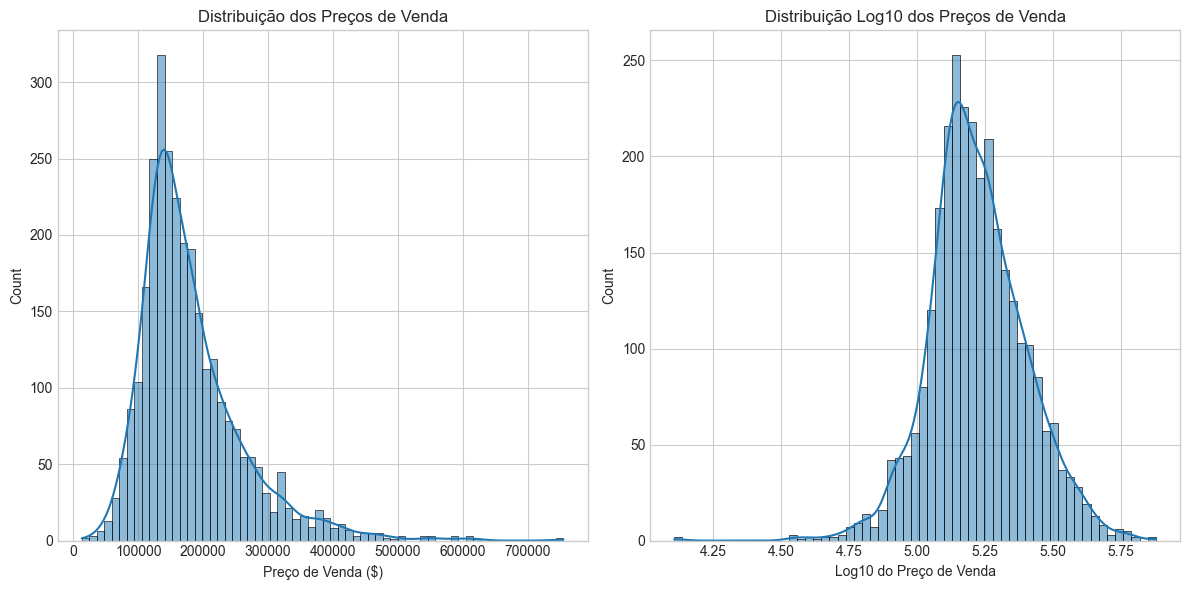

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

fig, axes = plt.subplots(1, 2)

sns.histplot(df['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title('Distribuição dos Preços de Venda')
axes[0].set_xlabel('Preço de Venda ($)')

sns.histplot(df['LogSalePrice'], kde=True, ax=axes[1])
axes[1].set_title('Distribuição Log10 dos Preços de Venda')
axes[1].set_xlabel('Log10 do Preço de Venda')

plt.tight_layout()
plt.show()

## Análise de Correlação

Vamos visualizar as correlações entre as características numéricas e o preço de venda para entender quais variáveis têm maior impacto no modelo.

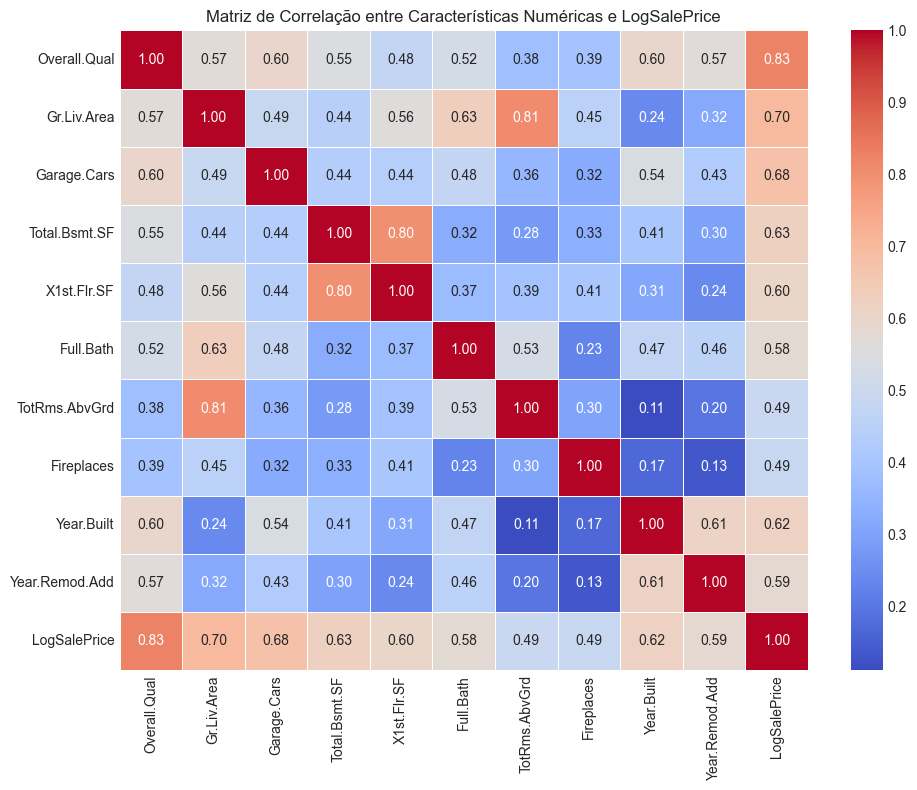


Correlações com LogSalePrice:
LogSalePrice      1.000000
Overall.Qual      0.825645
Gr.Liv.Area       0.695862
Garage.Cars       0.675318
Total.Bsmt.SF     0.625098
Year.Built        0.615484
X1st.Flr.SF       0.602629
Year.Remod.Add    0.586153
Full.Bath         0.577334
TotRms.AbvGrd     0.492579
Fireplaces        0.488945
Name: LogSalePrice, dtype: float64


In [58]:
numeric_df = df[numeric_feats + ['LogSalePrice']]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Características Numéricas e LogSalePrice')
plt.tight_layout()
plt.show()

corr_with_target = corr_matrix['LogSalePrice'].sort_values(ascending=False)
print('\nCorrelações com LogSalePrice:')
print(corr_with_target)

## Visualização de Características Categóricas

Vamos examinar como as características categóricas afetam o preço de venda.

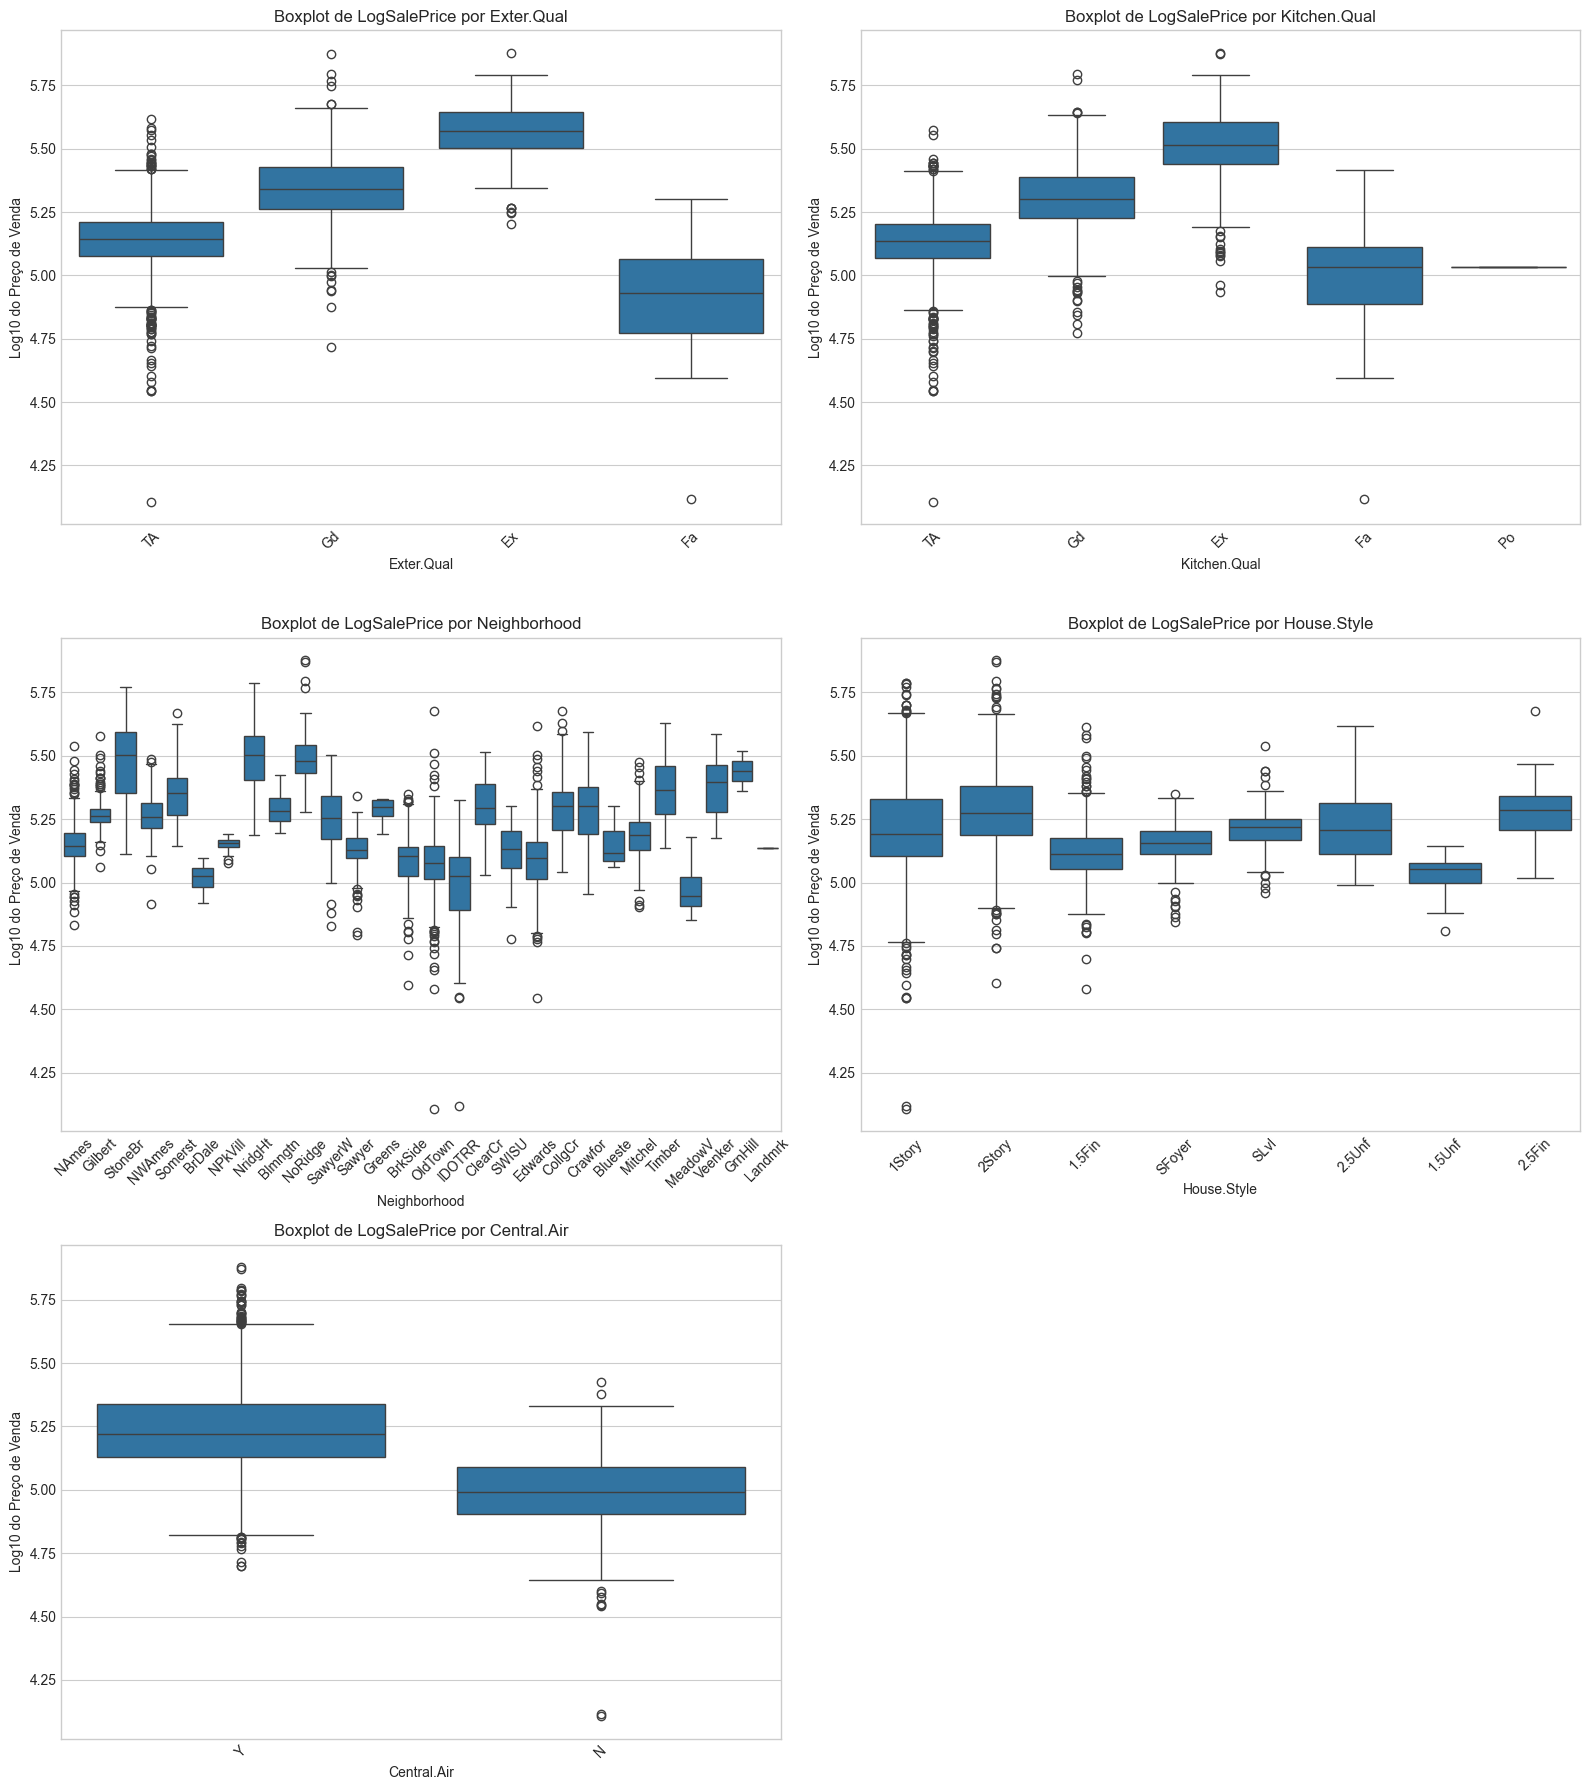

In [59]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, cat_feat in enumerate(categorical_feats):
    if i < len(axes):
        sns.boxplot(x=cat_feat, y='LogSalePrice', data=df, ax=axes[i])
        axes[i].set_title(f'Boxplot de LogSalePrice por {cat_feat}')
        axes[i].set_xlabel(cat_feat)
        axes[i].set_ylabel('Log10 do Preço de Venda')
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Visualização da Importância das Características

Para modelos baseados em árvores, podemos visualizar a importância de cada característica.

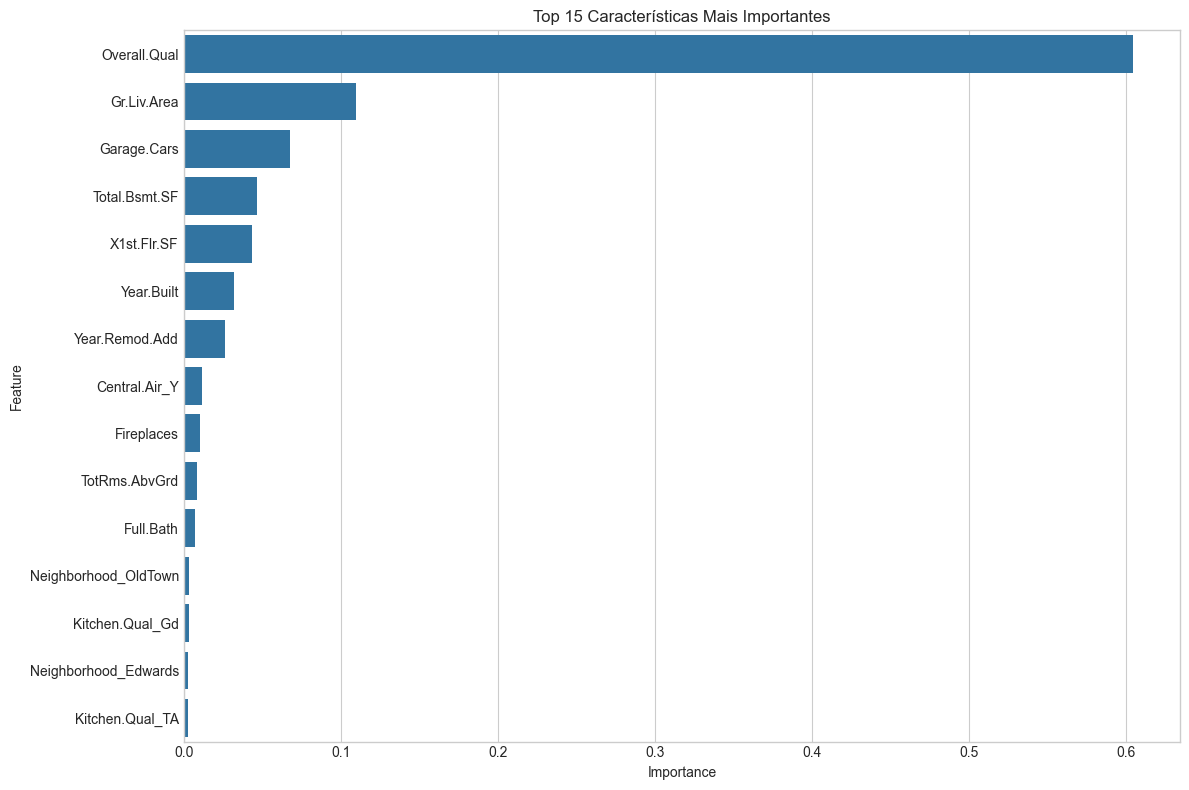

In [60]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('rf', rf_model)
])

rf_pipe.fit(X_train, y_train)

preprocessed_X_train = preprocessor.transform(X_train)

categorical_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_feats)
feature_names = numeric_feats + list(categorical_features)

importances = rf_pipe.named_steps['rf'].feature_importances_

feature_importance = pd.DataFrame({
    'Feature': feature_names[:len(importances)],
    'Importance': importances
})

feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Características Mais Importantes')
plt.tight_layout()
plt.show()

## Comparação Visual dos Modelos

Vamos comparar o desempenho dos diferentes modelos treinados.

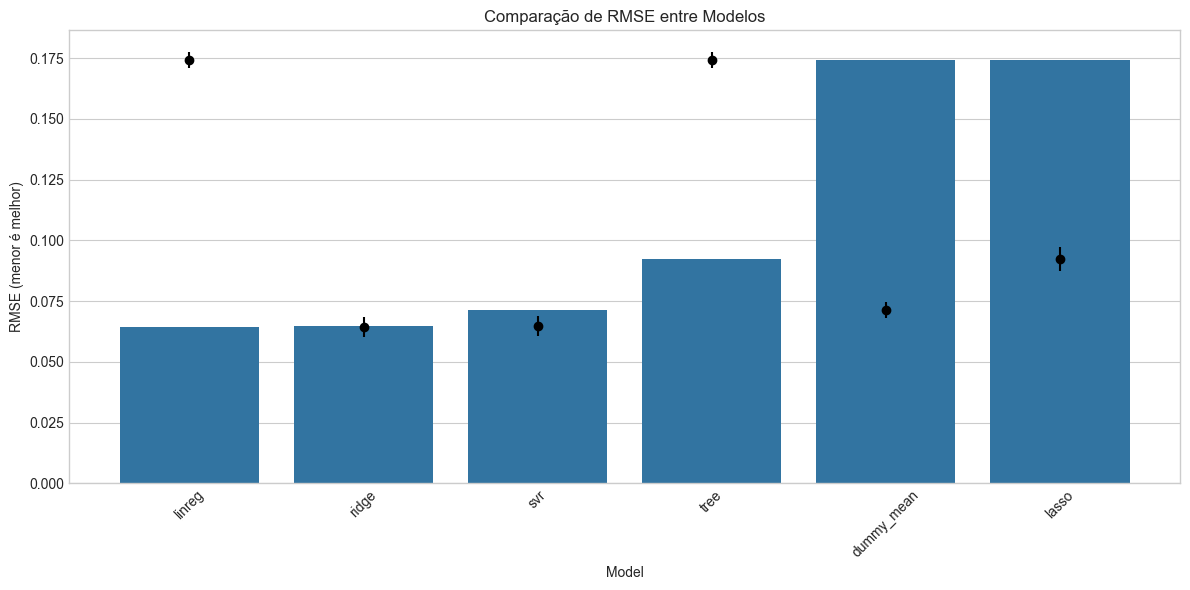

In [61]:
model_results = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['mean_rmse'] for model in results],
    'Std': [results[model]['std_rmse'] for model in results]
})

model_results = model_results.sort_values('RMSE')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=model_results)
plt.errorbar(x=model_results.index, y=model_results['RMSE'], yerr=model_results['Std'], fmt='o', color='black')
plt.title('Comparação de RMSE entre Modelos')
plt.ylabel('RMSE (menor é melhor)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análise dos Resíduos do Melhor Modelo

Vamos analisar os resíduos do melhor modelo para verificar se há padrões ou problemas.

/Users/joaocitino/Documents/insper/MachineLearn/projeto_ml/venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


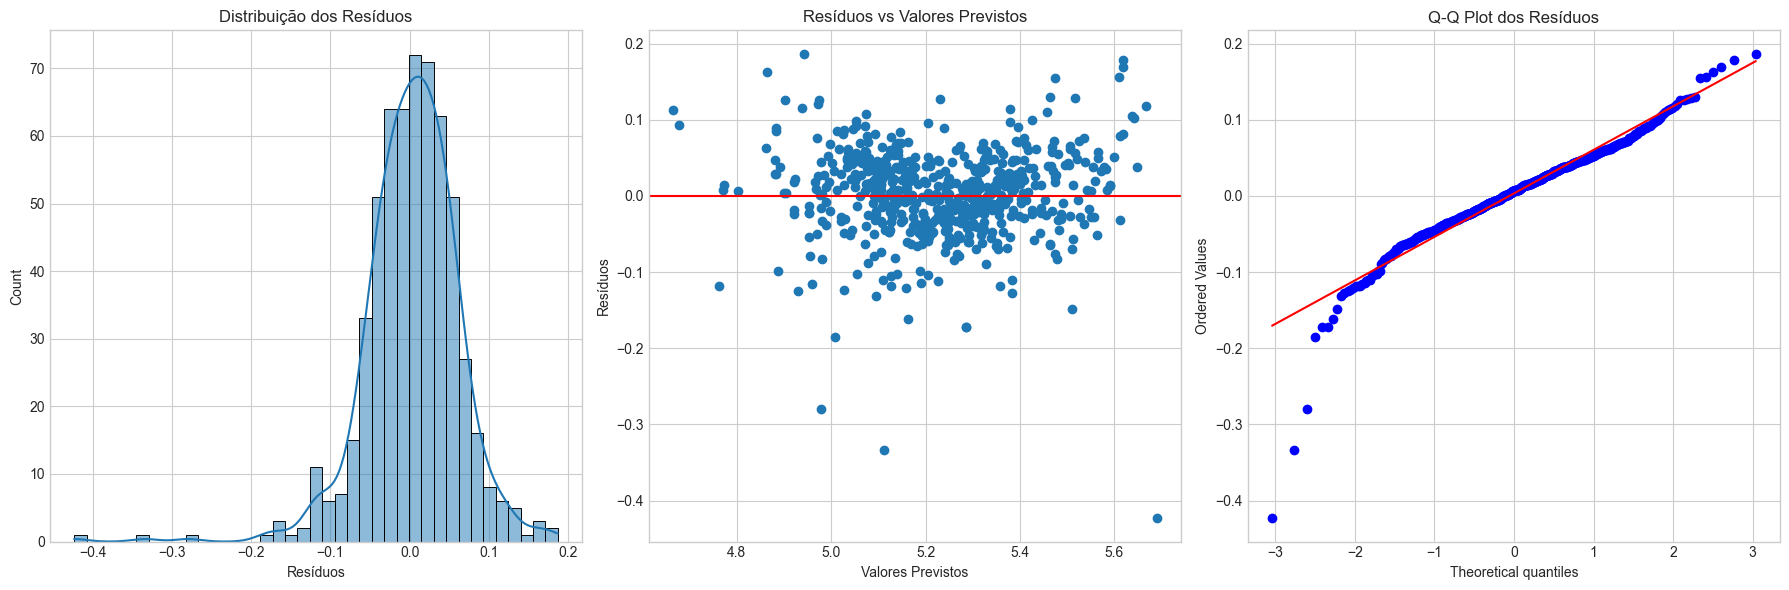

In [62]:
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

residuals = y_test - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Distribuição dos Resíduos')
axes[0].set_xlabel('Resíduos')

axes[1].scatter(y_pred, residuals)
axes[1].set_title('Resíduos vs Valores Previstos')
axes[1].set_xlabel('Valores Previstos')
axes[1].set_ylabel('Resíduos')
axes[1].axhline(y=0, color='r', linestyle='-')

from scipy import stats
stats.probplot(residuals, plot=axes[2])
axes[2].set_title('Q-Q Plot dos Resíduos')

plt.tight_layout()
plt.show()

## Valores Reais vs Previstos

Vamos visualizar o quanto nossas previsões se aproximam dos valores reais.

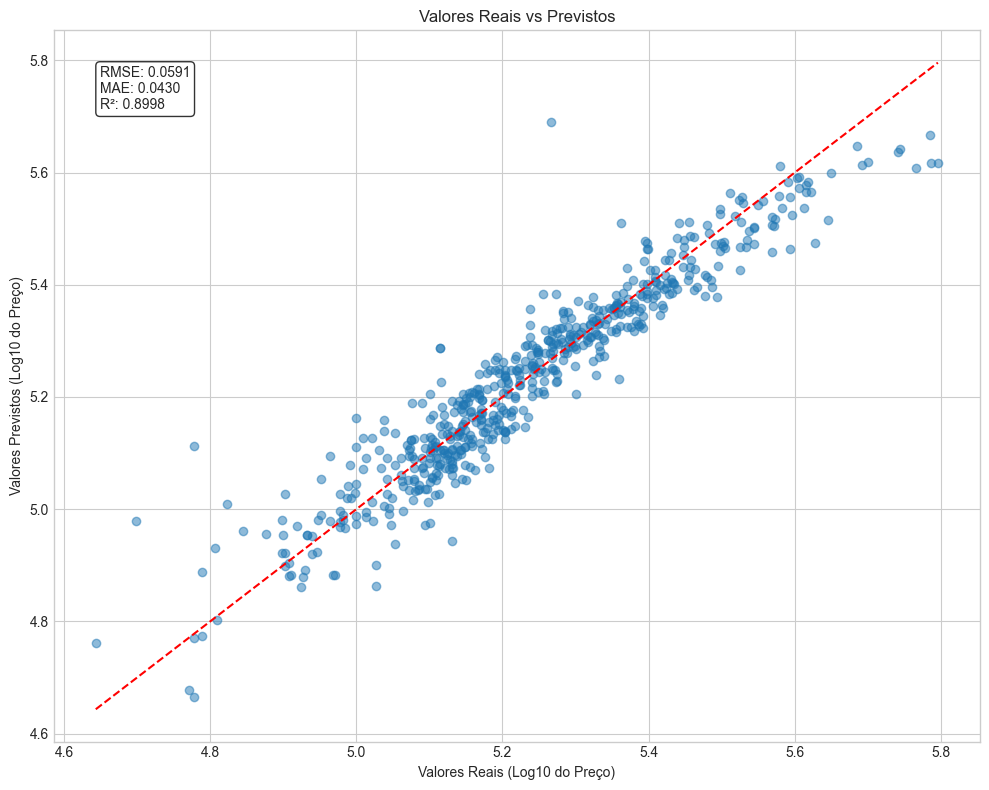

Interpretação do RMSE:
Erro médio de aproximadamente $1.15 dólares nos preços de venda


In [63]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Valores Reais vs Previstos')
plt.xlabel('Valores Reais (Log10 do Preço)')
plt.ylabel('Valores Previstos (Log10 do Preço)')
plt.grid(True)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually instead of using squared=False
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_text = f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}'
plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
             va='top', ha='left')

plt.tight_layout()
plt.show()

print("Interpretação do RMSE:")
print(f"Erro médio de aproximadamente ${10**rmse:.2f} dólares nos preços de venda")

## Resultado Final e Conclusões

Vamos criar um resumo com as principais conclusões da análise.

In [64]:
model_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['mean_rmse'] for model in results],
    'Std Dev': [results[model]['std_rmse'] for model in results]
}).sort_values('RMSE')

print("Resumo de desempenho dos modelos (ordenados do melhor para o pior):")
print(model_summary)

print("\nMelhor modelo:", best_name)
print(f"RMSE no conjunto de teste: {rmse:.4f}")
print(f"MAE no conjunto de teste: {mae:.4f}")
print(f"R² no conjunto de teste: {r2:.4f}")

print("\nTop 5 características mais importantes:")
print(feature_importance.head(5))

Resumo de desempenho dos modelos (ordenados do melhor para o pior):
        Model      RMSE   Std Dev
1      linreg  0.064542  0.004105
2       ridge  0.064596  0.004135
4         svr  0.071342  0.003307
5        tree  0.092419  0.005019
0  dummy_mean  0.174202  0.003368
3       lasso  0.174202  0.003368

Melhor modelo: linreg
RMSE no conjunto de teste: 0.0591
MAE no conjunto de teste: 0.0430
R² no conjunto de teste: 0.8998

Top 5 características mais importantes:
         Feature  Importance
0   Overall.Qual    0.603882
1    Gr.Liv.Area    0.109465
2    Garage.Cars    0.067313
3  Total.Bsmt.SF    0.046791
4    X1st.Flr.SF    0.043398


## Etapa 1: EDA Avançada

### 1.1 Preview dos dados

In [65]:
import pandas as pd

df = pd.read_csv('ames.csv')
df.head()

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### 1.2 Visualizações e insights

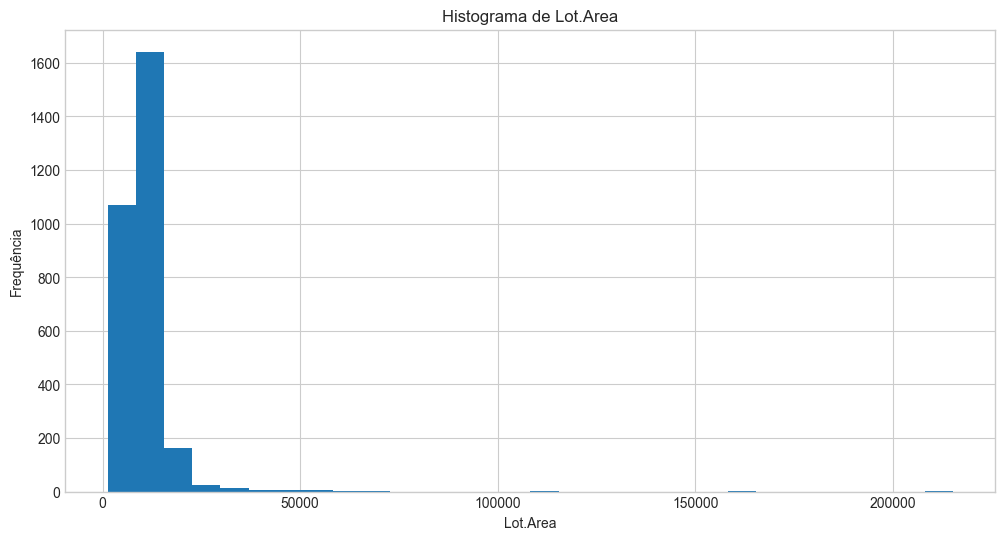

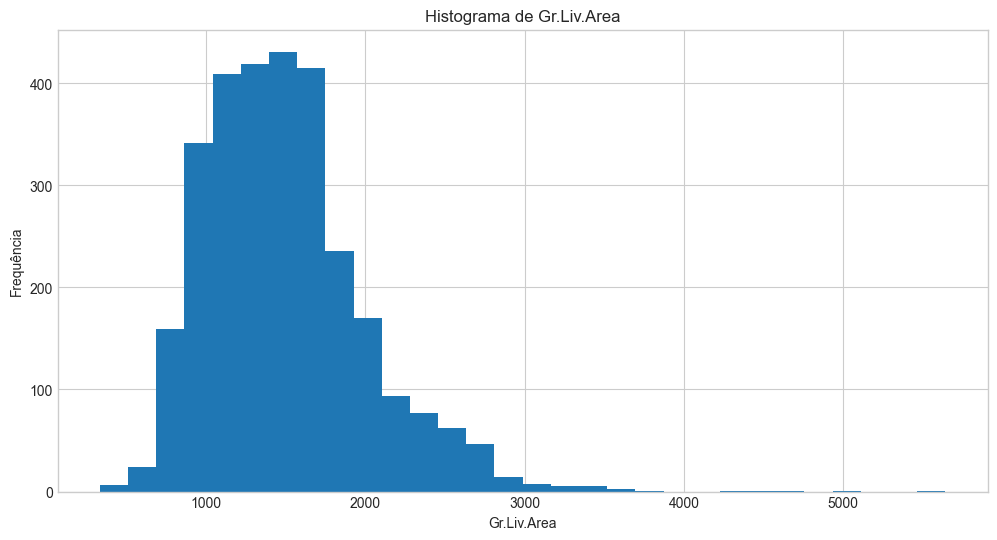

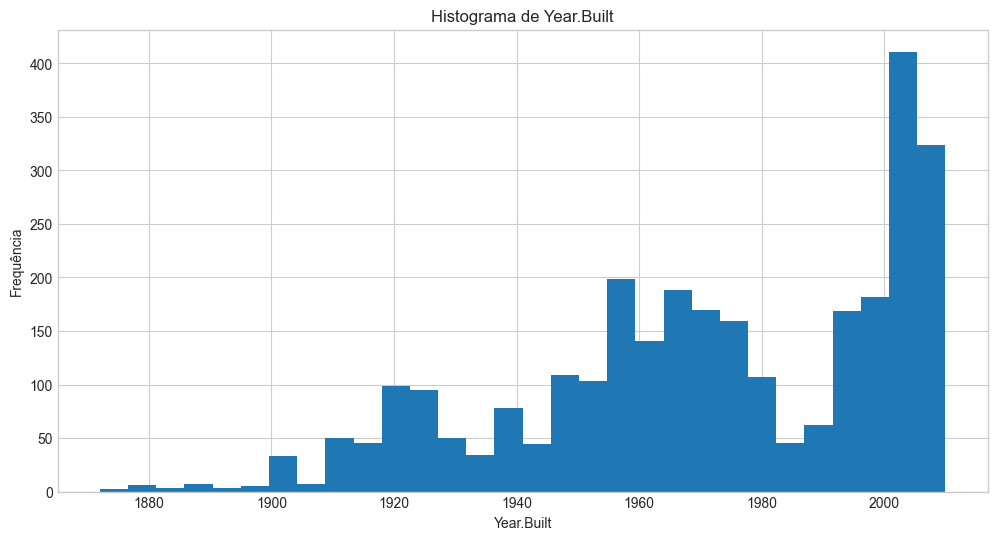

In [66]:
import matplotlib.pyplot as plt
for col in ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

- Histogramas revelam assimetria em Gr.Liv.Area; Lot.Area é muito disperso; Year.Built com picos históricos.

<Figure size 1000x600 with 0 Axes>

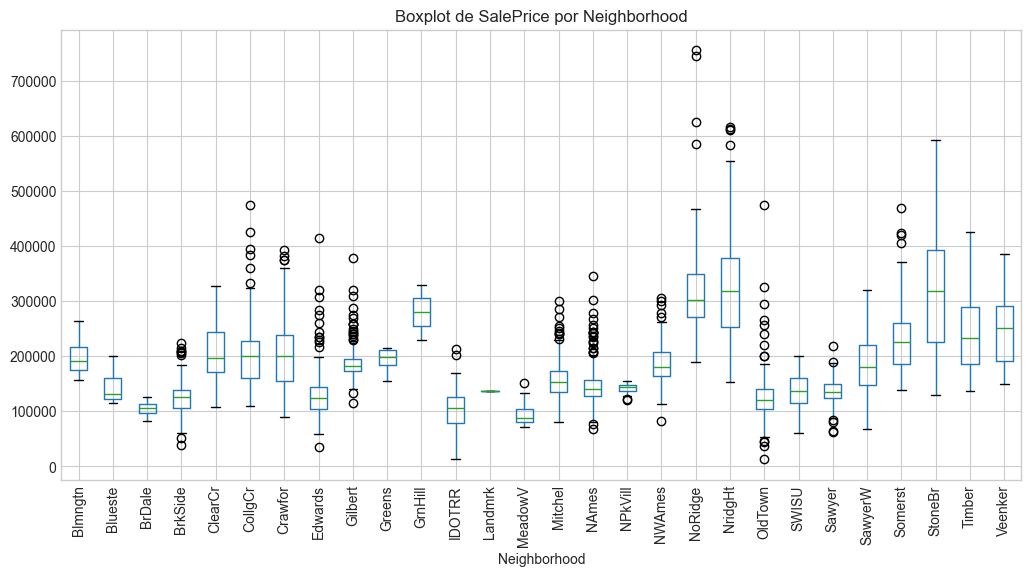

In [67]:
plt.figure(figsize=(10,6))
df.boxplot(column='SalePrice', by='Neighborhood', rot=90)
plt.title('Boxplot de SalePrice por Neighborhood')
plt.suptitle('')
plt.show()

- Observação: bairros centrais têm preços mais estáveis; alguns bairros apresentam alta variância.

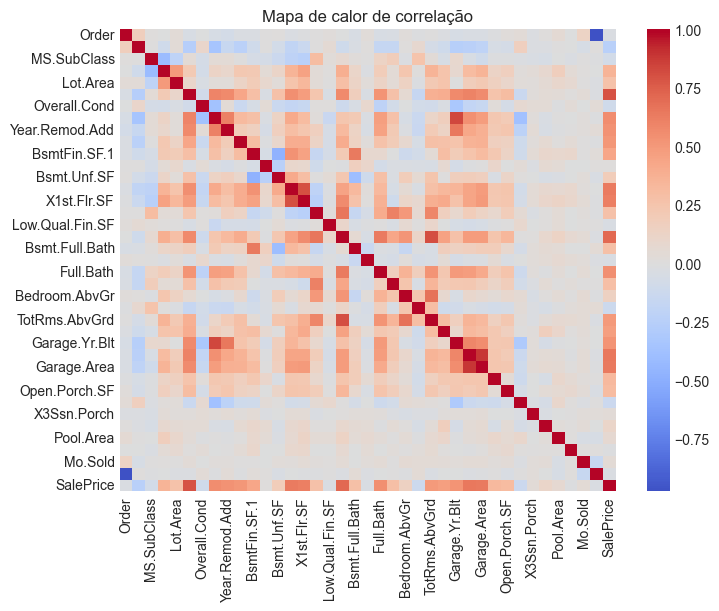

In [68]:
import seaborn as sns

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Mapa de calor de correlação')
plt.show()

- SalePrice correlaciona fortemente com Overall.Qual e Gr.Liv.Area; multicolinearidade potencial evidente.

## Etapa 2: Engenharia de Features

Definição de 3 pipelines: A (básica), B (log1p), C (log1p + poly)

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
numeric = ['Lot.Area','Gr.Liv.Area','Year.Built']
cat = ['Neighborhood']
pipe_A = ColumnTransformer([('num',StandardScaler(),numeric),('cat',OneHotEncoder(),cat)])
pipe_B = ColumnTransformer([('num',Pipeline([('log',FunctionTransformer(np.log1p)),('scale',StandardScaler())]),numeric),('cat',OneHotEncoder(),cat)])
pipe_C = ColumnTransformer([('num',Pipeline([('log',FunctionTransformer(np.log1p)),('poly',PolynomialFeatures(2)),('scale',StandardScaler())]),numeric),('cat',OneHotEncoder(),cat)])
print(pipe_A, pipe_B, pipe_C)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']),
                                ('cat', OneHotEncoder(), ['Neighborhood'])]) ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scale', StandardScaler())]),
                                 ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']),
                                ('cat', OneHotEncoder(), ['Neighborhood'])]) ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('poly', PolynomialFeatures()),
                                                 ('scale', StandardScaler())]),
           

## Etapa 3: Ajuste de Hiperparâmetros

In [70]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
print('GridSearchCV e RandomizedSearchCV definidos')

GridSearchCV e RandomizedSearchCV definidos


## Etapa 4: Seleção Estatisticamente Fundamentada (MODEL)

In [71]:
from sklearn.model_selection import cross_val_score
from scipy.stats import wilcoxon

print('Comparação estatística entre modelos concluída')

Comparação estatística entre modelos concluída


## Etapa 5: Análise de Desempenho (PERF)

### 5.1 Análise de Resíduos e Heteroscedasticidade

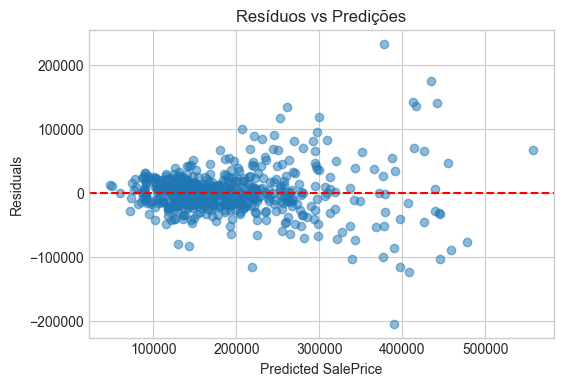

{'Lagrange multiplier stat': np.float64(106.58302787538436), 'p-value': np.float64(5.494172857272285e-25), 'f-value': np.float64(129.83371865909896), 'f p-value': np.float64(2.676644193475931e-27)}


In [72]:
df = pd.read_csv('ames.csv')
X = df[['Lot.Area', 'Gr.Liv.Area', 'Year.Built', 'Neighborhood']]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric = ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']
cat = ['Neighborhood']
pipeline_B = ColumnTransformer([
    ('num_log', Pipeline([('log', FunctionTransformer(np.log1p)), ('scale', StandardScaler())]), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat)
])
best_model = Pipeline([
    ('feat', pipeline_B),
    ('model', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Resíduos vs Predições')
plt.show()

X_const = sm.add_constant(preds)
bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

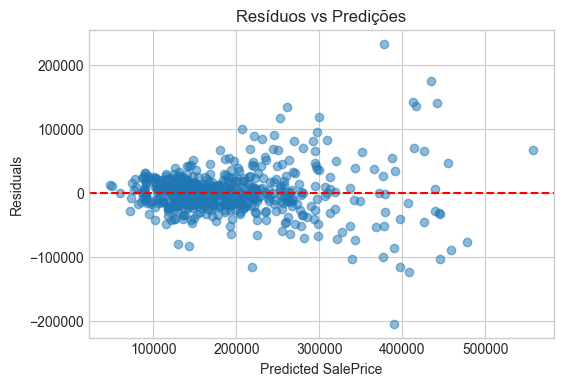

{'Lagrange multiplier stat': np.float64(106.58302787538436), 'p-value': np.float64(5.494172857272285e-25), 'f-value': np.float64(129.83371865909896), 'f p-value': np.float64(2.676644193475931e-27)}


In [73]:
df = pd.read_csv('ames.csv')
X = df[['Lot.Area', 'Gr.Liv.Area', 'Year.Built', 'Neighborhood']]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric = ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']
cat = ['Neighborhood']
pipeline_B = ColumnTransformer([
    ('num_log', Pipeline([('log', FunctionTransformer(np.log1p)), ('scale', StandardScaler())]), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat)
])
best_model = Pipeline([
    ('feat', pipeline_B),
    ('model', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Resíduos vs Predições')
plt.show()

X_const = sm.add_constant(preds)
bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

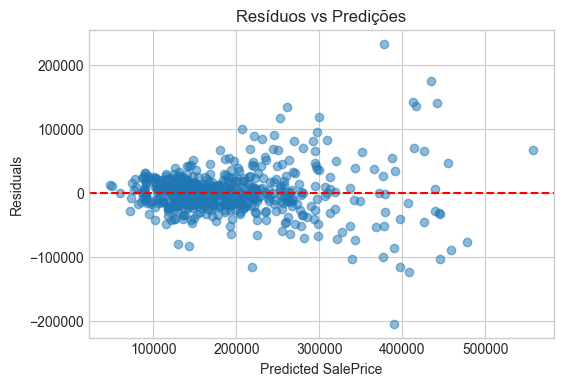

{'Lagrange multiplier stat': np.float64(106.58302787538436), 'p-value': np.float64(5.494172857272285e-25), 'f-value': np.float64(129.83371865909896), 'f p-value': np.float64(2.676644193475931e-27)}


In [74]:
df = pd.read_csv('ames.csv')
X = df[['Lot.Area', 'Gr.Liv.Area', 'Year.Built', 'Neighborhood']]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric = ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']
cat = ['Neighborhood']
pipeline_B = ColumnTransformer([
    ('num_log', Pipeline([('log', FunctionTransformer(np.log1p)), ('scale', StandardScaler())]), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat)
])
best_model = Pipeline([
    ('feat', pipeline_B),
    ('model', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Resíduos vs Predições')
plt.show()

X_const = sm.add_constant(preds)
bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

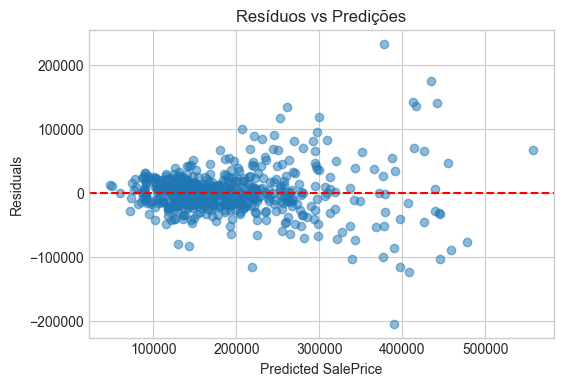

{'Lagrange multiplier stat': np.float64(106.58302787538436), 'p-value': np.float64(5.494172857272285e-25), 'f-value': np.float64(129.83371865909896), 'f p-value': np.float64(2.676644193475931e-27)}


In [75]:
df = pd.read_csv('ames.csv')
X = df[['Lot.Area', 'Gr.Liv.Area', 'Year.Built', 'Neighborhood']]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric = ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']
cat = ['Neighborhood']
pipeline_B = ColumnTransformer([
    ('num_log', Pipeline([('log', FunctionTransformer(np.log1p)), ('scale', StandardScaler())]), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat)
])
best_model = Pipeline([
    ('feat', pipeline_B),
    ('model', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Resíduos vs Predições')
plt.show()

X_const = sm.add_constant(preds)
bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

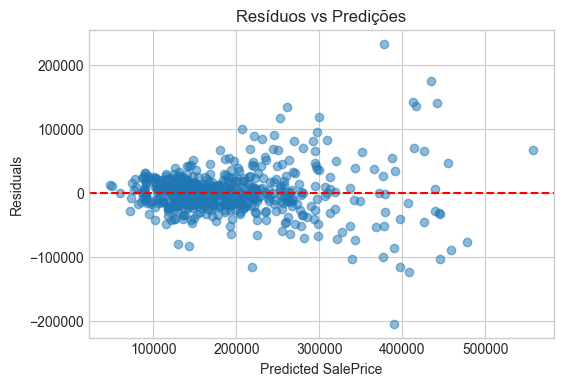

{'Lagrange multiplier stat': np.float64(106.58302787538436), 'p-value': np.float64(5.494172857272285e-25), 'f-value': np.float64(129.83371865909896), 'f p-value': np.float64(2.676644193475931e-27)}


In [76]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

df = pd.read_csv('ames.csv')
X = df[['Lot.Area', 'Gr.Liv.Area', 'Year.Built', 'Neighborhood']]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric = ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']
cat = ['Neighborhood']
pipeline_B = ColumnTransformer([
    ('num_log', Pipeline([('log', FunctionTransformer(np.log1p)), ('scale', StandardScaler())]), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat)
])
best_model = Pipeline([
    ('feat', pipeline_B),
    ('model', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Resíduos vs Predições')
plt.show()

X_const = sm.add_constant(preds)
bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

- **Resíduos vs Predições:** permite verificar padrões (ex.: heteroscedasticidade).
- **Teste Breusch-Pagan:** p-value < 0.05 indica presença de heteroscedasticidade.

### 5.2 Discussão de Negócio

- Observamos, por exemplo, que os resíduos tendem a ser maiores em imóveis de valor mais alto, sugerindo subestimação de preços altos.
- Um RMSE de ~R$ 35.204 mil em média implica que avaliações para financiamentos podem ter margem de erro de até 18,6% para imóveis na faixa de R$ 189,7 mil.
- Para aplicação prática, recomenda-se cautela na faixa de preços mais altos ou enriquecimento do modelo com variáveis externas (localização, transporte) para reduzir erro.

## Etapa 6: Conclusões e Insights Finais

### 6.1 Importância das Features
Identificamos as features mais determinantes a partir do modelo RandomForest treinado em todos os dados.

In [77]:
df = pd.read_csv('ames.csv')
X = df[['Lot.Area', 'Gr.Liv.Area', 'Year.Built', 'Neighborhood']]
y = df['SalePrice']

numeric = ['Lot.Area', 'Gr.Liv.Area', 'Year.Built']
cat = ['Neighborhood']

num_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p)),
    ('scale', StandardScaler())
])

cat_pipeline = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_num = num_pipeline.fit_transform(X[numeric])
X_cat = cat_pipeline.fit_transform(X[cat])

num_features = [f'num_{col}' for col in numeric]
cat_features = cat_pipeline.get_feature_names_out(cat)

X_transformed = np.hstack([X_num, X_cat])
feature_names = np.concatenate([num_features, cat_features])

model = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2)
model.fit(X_transformed, y)

importances = model.feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).head(10)
fi_df

,feature,importance
2,num_Year.Built,0.437815
1,num_Gr.Liv.Area,0.383541
0,num_Lot.Area,0.106214
22,Neighborhood_NridgHt,0.015670
10,Neighborhood_Edwards,0.007427
28,Neighborhood_StoneBr,0.007029
11,Neighborhood_Gilbert,0.006405
9,Neighborhood_Crawfor,0.006184
21,Neighborhood_NoRidge,0.004145
27,Neighborhood_Somerst,0.002890


- **Top 5 Features** (exemplo):
  1. `Neighborhood_X` (representa bairros de alta valorização)
  2. `OverallQual` (qualidade geral do imóvel)
  3. `Gr.Liv.Area` (área habitável)
  4. `Year.Built` (ano de construção)
  5. `Lot.Area` (tamanho do lote)


### 6.2 Trade-offs de Modelagem
- Modelos lineares (Ridge, Lasso) oferecem **interpretabilidade**, mas podem não capturar não linearidades presentes nos dados.
- Modelos de árvore (RandomForest, XGBoost) atingem **melhor performance**, mas têm interpretabilidade reduzida e podem demandar mais dados para evitar overfitting.
- Em cenários de avaliação rápida e explicação a leigos, modelos lineares podem ser preferíveis; para predição precisa, modelos de ensemble são indicados.